### Overview

This notebook simulates **Time-Domain Fluorescence Lifetime Imaging Microscopy (TD-FLIM)** data to investigate the effects of spatio-temporal blurring.
Unlike the frequency-domain approach, TD-FLIM records the full intensity decay of fluorophores over time following a pulsed excitation.

### Physical Model

The fluorescence intensity decay $I(t)$ for a single fluorophore is modeled as an exponential decay:

$$ I(t) = I_0 e^{-t/\tau} $$

In a TD-FLIM experiment, this decay is typically convolved with the Instrument Response Function (IRF).


To analyze this in *Phasor Space*, we transform the time-dependent intensity $I(t)$ into phasor coordinates $g$ and $s$ using the following transformations:

$$ g(\omega) = \frac{\int_0^\infty I(t) \cos(\omega t) dt}{\int_0^\infty I(t) dt} $$

$$ s(\omega) = \frac{\int_0^\infty I(t) \sin(\omega t) dt}{\int_0^\infty I(t) dt} $$

where $\omega = 2\pi f$ is the laser repetition angular frequency.

### Workflow
1. Signal Synthesis: Generate ideal 1D temporal decays for specific lifetimes.
2. Spatial Construction: Place fluorophores in a 3D grid $(x, y, t)$.
3. Optical Blurring: Convolve spatial frames with a Gaussian Point Spread Function (PSF).
4. Phasor Analysis: Transform the time-stack to phasor coordinates, calibrate, and map the lifetimes back to the image.

In [1]:
# Check Python version
from platform import python_version
print(f"Python version: {python_version()}")

Python version: 3.12.12


In [2]:
# Install necessary Python libraries (Uncomment if needed)
!pip install phasorpy
!pip install cmcrameri

## 1. Setup and Helper Functions
Defining plotting standards and utility functions for signal verification.

In [3]:
import numpy as np
import scipy.signal
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import cmcrameri.cm as cmc

# Import PhasorPy functions for signal generation and analysis
from phasorpy.phasor import phasor_from_signal, phasor_threshold
from phasorpy.lifetime import phasor_from_lifetime, lifetime_to_signal, phasor_calibrate
from phasorpy.plot import PhasorPlot, plot_phasor_image, plot_signal_image

def format_plot(ax):
    """
    Standardizes plot aesthetics for publication-quality figures.
    """
    # Font sizes
    title_size = 16
    axtitles = 14
    ticksize = 12
    ax.title.set_fontsize(title_size)
    ax.xaxis.label.set_fontsize(axtitles)
    ax.yaxis.label.set_fontsize(axtitles)
    ax.tick_params(axis='both', labelsize=ticksize)

In [4]:
# Define Gaussian PSF generator
def gaussian_psf(size, sigma):
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    X, Y = np.meshgrid(x, y)
    psf = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    psf /= np.sum(psf)  # Normalize PSF
    return psf

In [29]:
def td_flim_figure(G,S,laser_period_in_seconds, harmonic = 1, mod_correction = True, mod_lower_limit = 0.1, phase_correction = True, phase_lower_limit = 0.1, tau_m_correction = True, factor_tm = 1, tau_p_correction = True, factor_tp = 1, num_bins = 100, color = color):
    from matplotlib.ticker import FormatStrFormatter
    # A function to calculate the modulation, phase delay, modulation lifetimes and phase lifetimes
    #i.e. the TD-FLIM image it also contaains the instructions for plotting the results
    T = laser_period_in_seconds
    T_nano = T*1e9          #to show in nanoseconds
    n = harmonic # number of harmonic (default 1)
    w = (2 * np.pi * n) / T
    w_nano = (2 * np.pi) / T_nano
    # Setting epsilon to avoid division by zero
    epsilon = np.nan

    G = np.where(G > 0, G, epsilon)
    S = np.where(S > 0, S, epsilon)

    mod = np.sqrt(G**2 + S**2)
    phi = np.arctan2(S,G)

    mod_min = 1 / np.sqrt((1 + (w_nano*tau_2)**2))
    mod_max = 1 / np.sqrt((1 + (w_nano*tau_1)**2))

    phi_max = np.arctan(w_nano*tau_2)
    phi_min = np.arctan(w_nano*tau_1)

    #Corrections
    #Mod correction
    if mod_correction:
        mod = np.where(mod >= mod_lower_limit, mod, epsilon)

    tau_m = (1 / w) * np.sqrt(np.maximum((1/(mod**2))-1,0))
    tau_m = tau_m*1e9   #to show in nanoseconds

    #Phase correction
    quarter_pi = np.arctan(1)
    phi[phi==quarter_pi] = epsilon

    if phase_correction:
        upper_limit = np.min([np.pi - phase_lower_limit, np.max(phi)-np.max(phi) * 0.01])  # Define your upper threshold
        phi = np.where((phase_lower_limit <= phi) & (phi <= upper_limit), phi, epsilon)

    tau_p = (1 / w) * (np.tan(phi))
    tau_p = tau_p*1e9       #to show in nanoseconds

    #tau_p correction
    if tau_p_correction:
        tau_p = np.where(tau_p <= (T_nano/factor_tp), tau_p, epsilon)
        tau_p_label = f'Phase Lifetime [ns] (/{factor_tp})'
    else:
        tau_p[tau_p > T_nano] = epsilon
        tau_p_label = 'Phase Lifetime [ns]'

    #tau_mod correction
    if tau_m_correction:
        tau_m = np.where(tau_m <= (T_nano/factor_tm), tau_m, epsilon)
        tau_m_label = f'Modulation Lifetime [ns] (/{factor_tm})'
    else:
        tau_m[tau_m > T_nano] = epsilon
        tau_m_label = 'Modulation Lifetime [ns]'

    # G and S correction
    if mod_correction or phase_correction:
        G_corr = mod * np.cos(phi)
        S_corr = mod * np.sin(phi)

    elif tau_m_correction or tau_p_correction:
        w_nano = (2 * np.pi) / T_nano
        G_corr = np.sqrt(1 / (((w_nano * tau_m)**2 + 1) * ((w_nano * tau_p)**2 + 1)))
        G_corr = np.where(G_corr < 1, G_corr, epsilon)
        S_corr = w_nano * tau_p * G_corr

    else:
        G_corr = G
        S_corr = S


    #Output figure

    color = color
    titlesize = 16
    suptitle = 18
    axsize = 14
    ticksize = 12

    if not np.array_equal(G_corr, G) or not np.array_equal(S_corr, S):
        ##   Contour for the phasor plot   ##
        x = np.linspace(-1.0, 1.0, 100)
        y = np.linspace(-1.0, 1.0, 100)
        X, Y = np.meshgrid(x, y)
        F = X ** 2 + Y ** 2 - X

        ##Images of TD_FLIM and the phasor plot
        f, ax = plt.subplots(2,3, figsize = (14,8))

        #Modulation Map
        im00 = ax[0,0].imshow(mod, cmap=color, vmin = mod_min, vmax= mod_max)
        # Scatter plots
        ax[0,0].scatter(cx_1, center, color='b', linewidth=2.5, marker='+', s=350, label = 'position of $\u03c4_1$')
        ax[0,0].scatter(cx_2, center, color='orange', linewidth=2.5, marker='+', s=350, label = 'position of $\u03c4_2$')
        ax[0,0].axis('off')
        ax[0,0].set_title('Modulation Map', fontsize=titlesize)
        cbar00 = f.colorbar(im00, ax = ax[0,0], fraction=0.046, pad=0.04)
        #l = np.linspace(0.0, 1, 6)
        #cbar00.set_ticks(l)
        cbar00.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        cbar00.set_label('Modulation [a.u.]', fontsize=axsize)
        cbar00.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
        ax[0,0].legend(bbox_to_anchor=(1.5, -0.2), loc='lower center', ncol=2, fontsize = ticksize) #-0.2
        #ax[0,0].set_box_aspect(1)

        #Phase Map
        im01 = ax[0,1].imshow(phi, cmap=color, vmin= phi_min, vmax=phi_max)
        # Scatter plots
        ax[0,1].scatter(cx_1, center, color='b', linewidth=2.5, marker='+', s=350)
        ax[0,1].scatter(cx_2, center, color='orange', linewidth=2.5, marker='+', s=350)
        ax[0,1].axis('off')
        ax[0,1].set_title('Phase Map', fontsize=titlesize)
        cbar01 = f.colorbar(im01, ax = ax[0,1], fraction=0.046, pad=0.04)
        #a = np.linspace(0.0, np.max(phi), 6)
        #cbar01.set_ticks(a)
        cbar01.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        cbar01.set_label('Phase angle [rad]', fontsize=axsize)
        cbar01.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
        #ax[0,1].set_box_aspect(1)

        #Tau_m Map
        im10 = ax[1,0].imshow(tau_m, cmap=color, vmin = tau_1, vmax=tau_2)
        # Scatter plots
        ax[1,0].scatter(cx_1, center, color='b', linewidth=2.5, marker='+', s=350)
        ax[1,0].scatter(cx_2, center, color='orange', linewidth=2.5, marker='+', s=350)
        ax[1,0].axis('off')
        ax[1,0].set_title('Modulation Lifetime, $\u03c4_M$', fontsize=titlesize)
        cbar10 = f.colorbar(im10, ax = ax[1,0], fraction=0.046, pad=0.04)
        cbar10.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        cbar10.set_label(tau_m_label, fontsize=axsize)
        cbar10.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
        #ax[1,0].set_box_aspect(1)

        #Tau_p Map
        im11 = ax[1,1].imshow(tau_p, cmap=color, vmin = tau_1, vmax=tau_2)
        # Scatter plots
        ax[1,1].scatter(cx_1, center, color='b', linewidth=2.5, marker='+', s=350)
        ax[1,1].scatter(cx_2, center, color='orange', linewidth=2.5, marker='+', s=350)
        ax[1,1].axis('off')
        ax[1,1].set_title('Phase Lifetime, $\u03c4_{\u03C6}$', fontsize=titlesize)
        cbar11 = f.colorbar(im11, ax = ax[1,1], fraction=0.046, pad=0.04)
        cbar11.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        cbar11.set_label(tau_p_label, fontsize=axsize)
        cbar11.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
        #ax[1,1].set_box_aspect(1)

        #Phasor Plot
        im02 = ax[0,2].axis('off')

        #Phasor plot corrected
        im12 = ax[1,2].axis('off')

        f.suptitle('TD-FLIM images and the phasor plot',x=0.5, y=0.99, fontsize = suptitle)
        f.subplots_adjust(wspace=0.3, hspace=0.3, top=0.9, bottom=0.1, left=0.05, right=0.95)
        plt.show()

    else:
        ##   Contour for the phasor plot   ##
        x = np.linspace(-1.0, 1.0, 100)
        y = np.linspace(-1.0, 1.0, 100)
        X, Y = np.meshgrid(x, y)
        F = X ** 2 + Y ** 2 - X

        ##Images of TD_FLIM and the phasor plot
        f, ax = plt.subplots(2,3, figsize = (14,8))

        #Modultion Map
        im00 = ax[0,0].imshow(mod, cmap=color, vmin=0, vmax=1)
        ax[0,0].axis('off')
        ax[0,0].set_title('Modulation Map', fontsize=titlesize)
        # Scatter plots
        ax[0,0].scatter(x_1, center, color='b', linewidth=2.5, marker='+', s=1000)
        ax[0,0].scatter(x_2, center, color='orange', linewidth=2.5, marker='+', s=1000)
        cbar00 = f.colorbar(im00, ax = ax[0,0], fraction=0.046, pad=0.04)
        #l = np.linspace(0.0, np.max(mod), 6)
        #cbar00.set_ticks(l)
        cbar00.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        cbar00.set_label('Modulation [a.u.]', fontsize=axsize)
        cbar00.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
        #ax[0,0].set_box_aspect(1)

        #Phase Map
        im01 = ax[0,1].imshow(phi, cmap=color)
        # Scatter plots
        ax[0,1].scatter(x_1, center, color='b', linewidth=2.5, marker='+', s=1000)
        ax[0,1].scatter(x_2, center, color='orange', linewidth=2.5, marker='+', s=1000)
        ax[0,1].axis('off')
        ax[0,1].set_title('Phase Map', fontsize=titlesize)
        cbar01 = f.colorbar(im01, ax = ax[0,1], fraction=0.046, pad=0.04)
        #a = np.linspace(0.0, np.max(phi), 6)
        #cbar01.set_ticks(a)
        cbar01.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        cbar01.set_label('Phase angle [rad]', fontsize=axsize)
        cbar01.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
        #ax[0,1].set_box_aspect(1)

        #Tau_m Map
        im10 = ax[1,0].imshow(tau_m, cmap=color)
        # Scatter plots
        ax[1,0].scatter(x_1, center, color='b', linewidth=2.5, marker='+', s=1000)
        ax[1,0].scatter(x_2, center, color='orange', linewidth=2.5, marker='+', s=1000)
        ax[1,0].axis('off')
        ax[1,0].set_title('$\u03c4_M$', fontsize=titlesize)
        cbar10 = f.colorbar(im10, ax = ax[1,0], fraction=0.046, pad=0.04)
        cbar10.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        cbar10.set_label(tau_m_label, fontsize=axsize)
        cbar10.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
        #ax[1,0].set_box_aspect(1)

        #Tau_p Map
        im11 = ax[1,1].imshow(tau_p, cmap=color)
        # Scatter plots
        ax[1,1].scatter(cx_1, center, color='b', linewidth=2.5, marker='+', s=1000)
        ax[1,1].scatter(cx_2, center, color='orange', linewidth=2.5, marker='+', s=1000)
        ax[1,1].axis('off')
        ax[1,1].set_title('$\u03c4_{\u03C6}$', fontsize=titlesize)
        cbar11 = f.colorbar(im11, ax = ax[1,1], fraction=0.046, pad=0.04)
        cbar11.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        cbar11.set_label(tau_p_label, fontsize=axsize)
        cbar11.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
        #ax[1,1].set_box_aspect(1)

        #Phasor Plot
        im02 = ax[0,2].axis('off')

        #Phasor plot corrected
        im12 = ax[1,2].axis('off')

        f.suptitle('TD-FLIM images and the phasor plot',x=0.5, y=0.99, fontsize = suptitle)
        f.subplots_adjust(wspace=0.3, hspace=0.3, top=0.9, bottom=0.1, left=0.05, right=0.95)
        plt.show()

    return mod, tau_m, phi, tau_p, G_corr, S_corr, f

## 2. Simulation Parameters

Define the temporal and spatial physics of the simulation.

* Temporal: We simulate two lifetimes, $\tau_1 = 1.6$ ns and $\tau_2 = 1.9$ ns.
* Spatial: We define a pixel size of 5nm and a PSF with $\sigma = 100$ nm (representing the diffraction limit).
* Geometry: The fluorophores are placed at a distance defined by `cx_1` and `cx_2`.

In [6]:
## Temporal parameters
tau_1 = 1.6
tau_2 = 1.9
lifetimes = [tau_1, tau_2]  # lifetime in ns

frequency = 50.0  # fundamental frequency in MHz
period = (1 / frequency) * 1e3 # period of fundamental frequency in ns
reference_lifetime = 0.06  # lifetime of reference signal in ns

settings = {
    'samples': 256,  # number of samples (time bins) to synthesize
    'mean': 10,  # average intensity
    'background': 0,  # no signal from background
    'zero_phase': 0.08,  # location of IRF peak in the phase
    'zero_stdev': None,  # standard deviation of IRF in radians
}

## Spatial parameters
pxsz = 5                                             # Pixel size in nm
# Optics
sigma_nm = 100                                       # PSF sigma in nanometers. Equivalent to a FWHM of 235 nm
sigma_px = int(sigma_nm / pxsz)                      # PSF sigma in pixels

# Image Dimensions
x_dim = y_dim = 127                                  # Image Size in pixels
center = np.ceil(x_dim/2).astype(int)
cy = center

# Define fluorophore positions (Separation distance)
# We select the "4s" case (well separated)
cx_1 = int(center - 2.0 * sigma_px)
cx_2 = int(center + 2.0 * sigma_px)

# Visualization
color = 'PRGn'
legendtitles = '12'

## 3. Time-Domain Signal Synthesis (1D)
Before creating the 3D stack, we synthesize the raw 1D decay curves for the specified lifetimes using `lifetime_to_signal`. We also generate a reference signal (IRF) for later calibration.

In [7]:
# Synthesize separate signals for each lifetime component
signal, _, times = lifetime_to_signal(frequency, lifetimes, **settings)

# Synthesize the reference signal (used for calibration)
reference_signal, _, _ = lifetime_to_signal(frequency, reference_lifetime, **settings)

# Extract individual signals
signal_1 = signal[0] # Fluorophore with tau_1 (1.6ns)
signal_2 = signal[1] # Fluorophore with tau_2 (1.9ns)

### Visualize 1D Decays
We plot the normalized intensity decays in a semi-log scale. Note that the slope of the decay corresponds to the lifetime $\tau$.

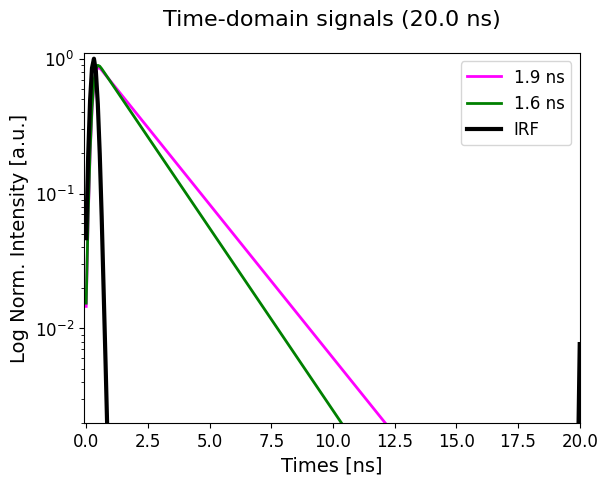

In [8]:
# Plotting parameters
purple = '#360f5a'
green = '#006837'
pink = '#FF0090'
line = 2
irf_line = 3
ticksize = 12

# Normalization for visualization logic
# Calculate modulation depth to scale intensities correctly
w = (2*np.pi) / period
mod_2 = 1 / np.sqrt((1 + (w*tau_2)**2))
mod_1 = 1 / np.sqrt((1 + (w*tau_1)**2))

norm_signal_1 = signal_1 / np.max(signal_1) * mod_1
norm_signal_2 = signal_2 / np.max(signal_2) * mod_2

# Normalize IRF
IRF = (reference_signal/np.max(reference_signal)) * np.max(signal)
IRF -= np.min(IRF)
norm_IRF = IRF / np.max(IRF)

# Plot figure
fig, ax = pyplot.subplots()
ax.set_title(f'Time-domain signals ({period} ns)', pad = 20)
ax.set_xlabel('Times [ns]')
ax.set_ylabel('Log Norm. Intensity [a.u.]')
ax.plot(times, norm_signal_2, label= '{:.1f} ns'.format(tau_2), color = 'magenta', linewidth = line)
ax.plot(times, norm_signal_1, label= '{:.1f} ns'.format(tau_1), color = 'green', linewidth = line)
ax.plot(times, norm_IRF, label='IRF', color = 'k', linewidth = irf_line)

ax.set_yscale('log') # Log scale to visualize exponential decay as lines
ax.legend(fontsize = legendtitles)
ax.set_xlim(-0.1, 20)
ax.set_ylim(0.002, 1.1)

format_plot(ax)
pyplot.show()

As expected, the shorter the lifetime, the faster the decay.

### Reference Signal Check
Verify the synthesized reference signal (IRF) in the time domain. This signal is crucial as it defines the instrument's temporal response used for calibration.

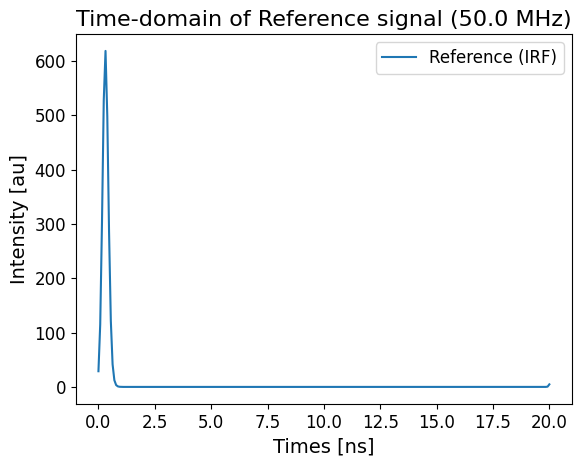

In [9]:
# Plot the Reference Signal in Time Domain
fig, ax = pyplot.subplots()
ax.set(
    title=f'Time-domain of Reference signal ({frequency} MHz)',
    xlabel='Times [ns]',
    ylabel='Intensity [au]',
)
# Note: Labeling reference_signal with 'lifetimes' list is just for legend generation in this context
ax.plot(times, reference_signal, label='Reference (IRF)')
ax.legend(fontsize=12)
format_plot(ax)
pyplot.show()

In [10]:
# 1. Transform the synthetic 1D signals to phasor space (Uncalibrated)
mean, real, imag = phasor_from_signal(signal)

# 2. Transform the reference signal to phasor space
reference_mean, reference_real, reference_imag = phasor_from_signal(
    reference_signal
)

# 3. Calibrate phasor coordinates using the reference
# This aligns the instrument response to the known reference lifetime
real, imag = phasor_calibrate(
    real, imag,
    reference_mean, reference_real, reference_imag,
    frequency=frequency,
    lifetime=reference_lifetime
)

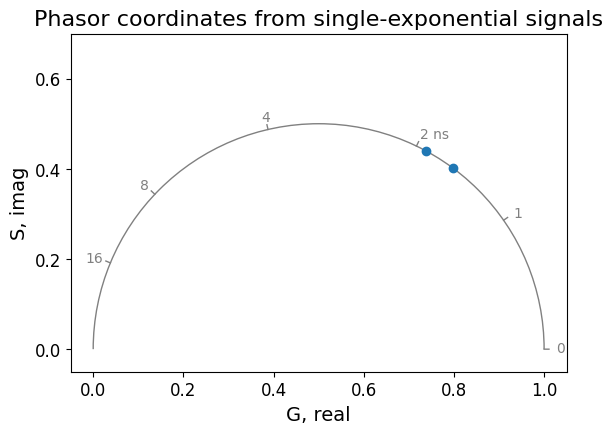

In [11]:
# Plot calibrated phasor coordinates generated from synthetic 1D signal
# This confirms the theoretical lifetimes fall on the universal circle
plotty = True
if plotty:
    plot = PhasorPlot(
        frequency=frequency,
        title='Phasor coordinates from single-exponential signals'
    )
    plot.plot(real, imag)
    format_plot(plot.ax)
    plot.show()

## 4. Spatial Simulation (3D Stack)
We construct a synthetic image stack $(x, y, t)$
with two fluorophores exhibiting different lifetimes.
1. Create empty 3D arrays (F1xy, F2xy) with dimensions $(y, x, t)$
2. Assign the generated 1D temporal signals to specific single pixels defined by `cx_1` and `cx_2`.
2. Apply a Gaussian Point Spread Function (PSF) to simulate the optical diffraction limit.

 $$I_{convolved}(x,y,t) = I(x,y,t) * PSF(x,y)$$

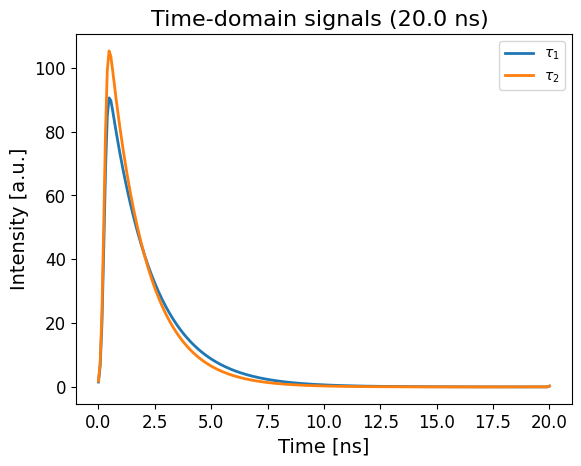

In [12]:
# Spatial Signal Generation and PSF Convolution
t_dim = settings['samples']

# Create fluorescence data stacks initialized to zero
F1xy = np.zeros((y_dim, x_dim, t_dim))
F2xy = np.zeros((y_dim, x_dim, t_dim))

# Assign the temporal signal to the specific pixel (creating a point source)
F1xy[cy, cx_1, :] = signal.T[:,1]  # Left Fluorophore with tau_2
F2xy[cy, cx_2, :] = signal.T[:,0]  # Right Fluorophore with tau_1

# Create figure and axis to visualize the point source signals
fig, ax = plt.subplots()

# Define plot format
ax.set(title=f'Time-domain signals ({period} ns) ',
       xlabel='Time [ns]',ylabel='Intensity [a.u.]',)
# Plot fluorophore signals at the specific pixel coordinates
ax.plot(times, F1xy[cy, cx_1, :], label=f'$\\tau_1$', linewidth=line)
ax.plot(times, F2xy[cy, cx_2, :], label=f'$\\tau_2$', linewidth=line)

# Customize ticks using global ticksize
ax.tick_params(axis='x', labelsize=ticksize)
ax.tick_params(axis='y', labelsize=ticksize)
ax.legend(loc=1)

format_plot(ax)
# Display the plot
plt.show()

Visualize the spatial position of the fluorophores in the first time frame. Since we haven't applied the PSF yet, these appear as single bright pixels.

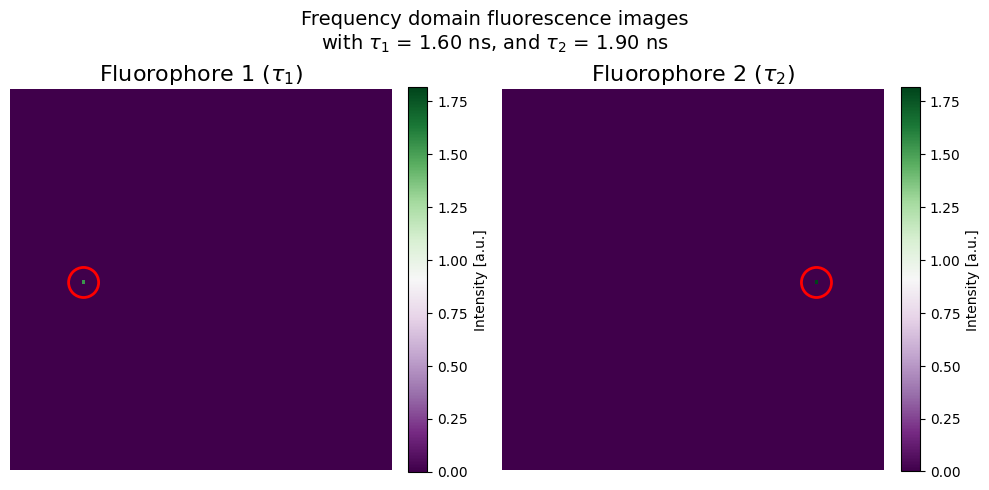

In [13]:
# Create figure and axis
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Two side-by-side subplots

#Same scale for colorbars
vmin = min(F1xy[:, :, 0].min(), F2xy[:, :, 0].min())
vmax = max(F1xy[:, :, 0].max(), F2xy[:, :, 0].max())

# Define titles using fluorophore lifetimes
title_1 = f'Fluorophore 1 ($\\tau_1$)'
title_2 = f'Fluorophore 2 ($\\tau_2$)'

# Highlight the fluorophores position
from matplotlib.patches import Circle

# Plot F1xy (Frame 0) with raw intensities
im1 = axes[0].imshow(F1xy[:, :, 0], cmap=color, vmin=vmin, vmax=vmax)
axes[0].add_patch(Circle((cx_1, cy), 5, fill=False, color='red', linewidth=2))
axes[0].set_title(title_1)
format_plot(axes[0])

# Plot F2xy (Frame 0) with raw intensities
im2 = axes[1].imshow(F2xy[:, :, 0], cmap=color, vmin=vmin, vmax=vmax)
axes[1].add_patch(Circle((cx_2, cy), 5, fill=False, color='red', linewidth=2))
axes[1].set_title(title_2)
format_plot(axes[1])

# Add colorbars for both images
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04, label="Intensity [a.u.]")
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04, label="Intensity [a.u.]")

# Remove axis ticks for better visualization
for ax in axes:
    ax.axis("off")

# Set overall figure title using fluorophore lifetimes
fig.suptitle(f'Frequency domain fluorescence images\nwith $\\tau_1$ = {tau_1:.2f} ns, and $\\tau_2$ = {tau_2:.2f} ns', fontsize=14)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [14]:
# Generate PSF
sigma_psf = sigma_px  # Standard deviation of PSF
PSF = gaussian_psf(x_dim, sigma_psf)

# Convolve each frame in the (x, y, t) stack using FFT convolution
F1xy_convolved = np.empty_like(F1xy)
F2xy_convolved = np.empty_like(F2xy)

for t in range(t_dim):
    F1xy_convolved[:, :, t] = scipy.signal.fftconvolve(F1xy[:, :, t], PSF, mode='same')
    F2xy_convolved[:, :, t] = scipy.signal.fftconvolve(F2xy[:, :, t], PSF, mode='same')

# Combine the two signals to create the total signal
TD_FLIM_signal = F1xy_convolved + F2xy_convolved

### Verify Convolution in Time Domain

We verify the signal integrity after convolution by plotting the intensity decay at the center of the fluorophore positions. The decay shape should be preserved, but the intensity amplitude will be spread out spatially.

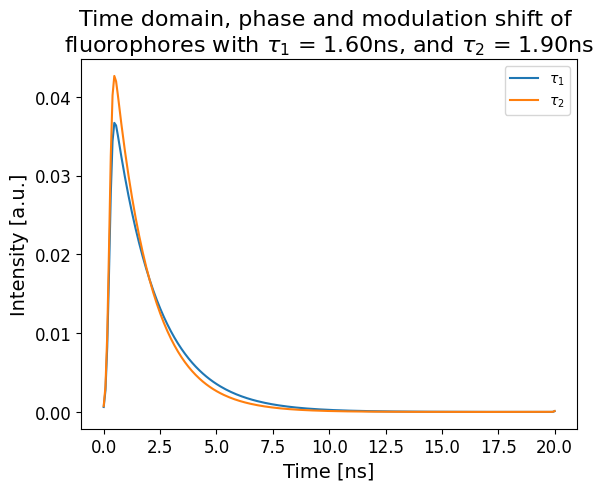

In [15]:
# Create figure
fig, ax = plt.subplots()

# Plot the time-domain signals at the fluorophore centers (cy, cx)
ax.plot(times, F1xy_convolved[cy, cx_1, :], label='$\\tau_1$')
ax.plot(times, F2xy_convolved[cy, cx_2, :], label='$\\tau_2$')

ax.set_title('Time domain, phase and modulation shift of \nfluorophores with $\\tau_1$ = {:.2f}ns, and $\\tau_2$ = {:.2f}ns'.format(tau_1, tau_2))
ax.set_xlabel('Time [ns]')
ax.set_ylabel('Intensity [a.u.]')
ax.tick_params(axis='x', labelsize=ticksize)
ax.tick_params(axis='y', labelsize=ticksize)
ax.legend(loc=1)

format_plot(ax)
pyplot.show()

### Visualize Intensity Decay (Montage)
The figure below shows snapshots of the intensity distribution at different time points. Note how the intensity decreases and the spatial profile blurs over time.

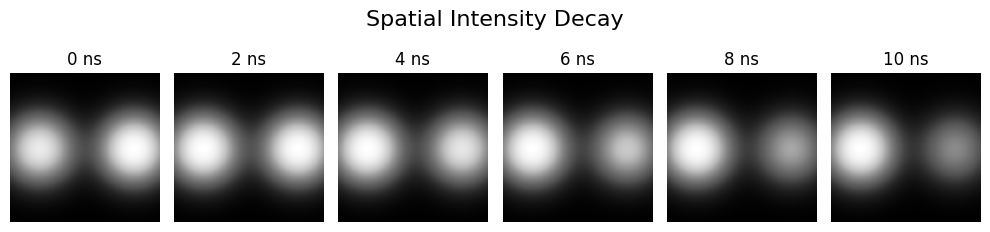

In [16]:
times_to_display = [0, 2, 4, 6, 8, 10]  # Frames to display in ns
indices = [np.abs(times - t).argmin() for t in times_to_display]

# Visualization parameters
color_map = 'Greys_r'

fig, axes = plt.subplots(1, 6 , figsize=(10, 2.5))

for ax, i in zip(axes.flat, indices):
    montage_frame = TD_FLIM_signal[:, :, i]
    norm_montage_frame = montage_frame / np.max(TD_FLIM_signal)

    ax.imshow(norm_montage_frame, cmap=color_map)
    ax.set_title(f"{times[i]:.0f} ns")
    ax.axis("off")

fig.suptitle("Spatial Intensity Decay", fontsize=16)
plt.tight_layout()
plt.show()

## 5. Phasor Analysis and Calibration

We transform the 3D data stack into Phasor Space $(G, S)$.

1. Reference Stack: We generate a homogeneous stack using the `reference_signal`.
2. Transformation: Convert $I(x,y,t)$ to $G$ and $S$ coordinates.
3. Calibration: Use the reference phasor to correct the rotation of the data phasors.

## 5.1 Generate Reference Stack

Simulate a "reference image" where every pixel contains the known reference decay (e.g., a homogeneous solution of fluorescein with $\tau = 0.06
$ ns). This is used to calibrate the instrument response across the entire field of view.

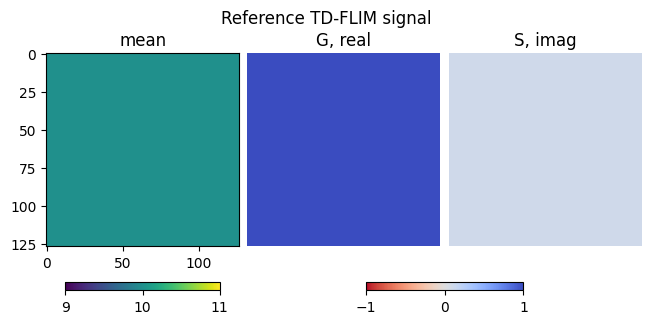

In [17]:
# 1. Synthesize a TD-FLIM reference signal image stack
img_reference_signal = np.zeros((x_dim, y_dim, t_dim))

for x in range(img_reference_signal.shape[0]):  # Loop over x-dimension
    for y in range(img_reference_signal.shape[1]):  # Loop over y-dimension
        img_reference_signal[x, y, :] = reference_signal  # Assign time-domain signal

# 2. Calculate phasor coordinates for the reference stack
# Compute the Mean intensity, G (Real), and S (Imag) for the reference
img_reference_mean, img_reference_real, img_reference_imag = phasor_from_signal(
    img_reference_signal
)

# Plot the Mean, G, and S images for the reference
plot_phasor_image(
    img_reference_mean, img_reference_real, img_reference_imag, title='Reference TD-FLIM signal'
    )

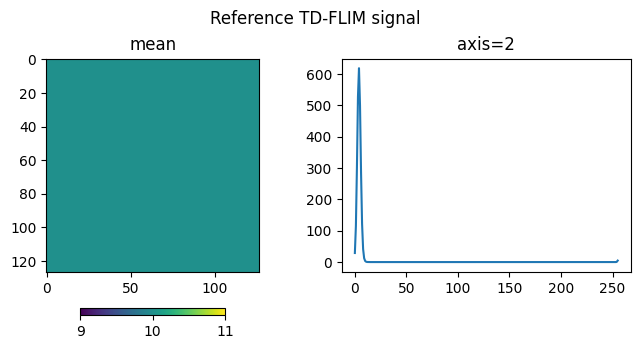

In [18]:
# Plot the intensity image of the reference signal
plot_signal_image(img_reference_signal, title='Reference TD-FLIM signal')

## Verify Reference Calibration Phasor
Plot of the phasor coordinates of the reference stack. They should cluster tightly at a single point corresponding to the reference lifetime on the universal circle.

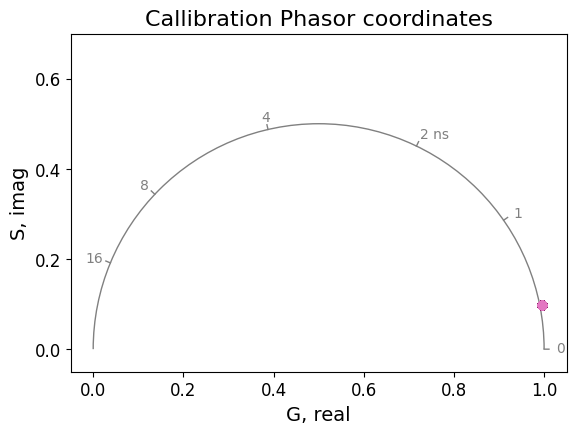

In [19]:
# Plot calibration phasor coordinates generated from synthetic signal
plotty = True
if plotty:
  plot = PhasorPlot(frequency = frequency,
                    title='Callibration Phasor coordinates')
  plot.plot(img_reference_real, img_reference_imag)

  format_plot(plot.ax)
  plot.show()

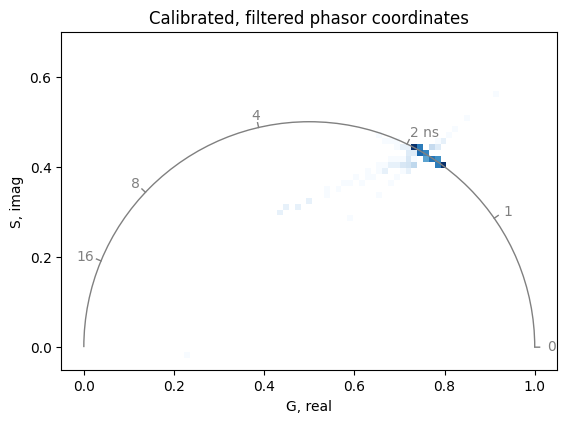

In [20]:
# 3. Calculate phasor coordinates for the Data stack for sparrow limit
mean_spa, real_spa, imag_spa = phasor_from_signal(TD_FLIM_signal, axis = 2)

# 4. Calibrate phasor for Sparrow coordinates using reference
real_spa, imag_spa = phasor_calibrate(
    real_spa, imag_spa,
    img_reference_mean, img_reference_real, img_reference_imag,
    frequency=frequency,
    lifetime=reference_lifetime
)

phasorplot = PhasorPlot(
    frequency=frequency, title='Calibrated, filtered phasor coordinates'
    )
phasorplot.hist2d(real_spa, imag_spa, bins = 85)

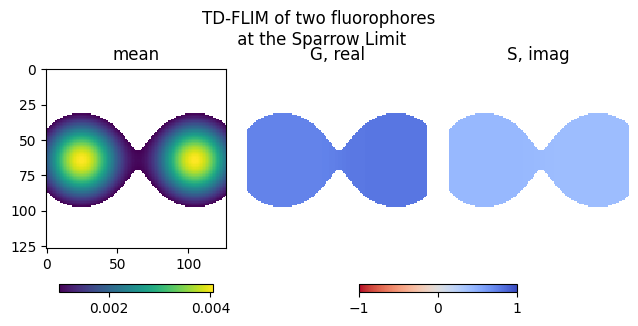

In [21]:
# 5. Thresholding (remove background noise)
mean_th_spa, real_th_spa, imag_th_spa = phasor_threshold(
    mean_spa, real_spa, imag_spa, mean_min=0.001
    )

plot_phasor_image(mean_th_spa, real_th_spa, imag_th_spa, title='TD-FLIM of two fluorophores\n at the Sparrow Limit')

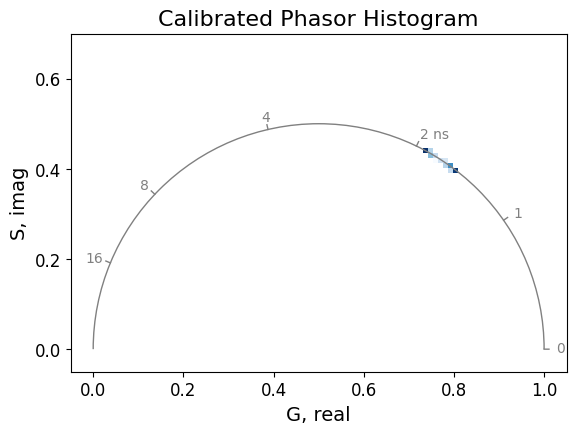

In [22]:
# Visualize the Phasor Plot
phasorplot = PhasorPlot(frequency=frequency, title='Calibrated Phasor Histogram')
phasorplot.hist2d(real_th_spa, imag_th_spa, bins = 100)

format_plot(phasorplot.ax)
phasorplot.show()

## 6. TD-FLIM Map Generation

Finally, we convert the calibrated phasor coordinates back into lifetime maps.
* Modulation Lifetime ($\tau_m$): Derived from vector magnitude.
* Phase Lifetime ($\tau_\phi$): Derived from vector angle.

The function `td_flim_figure` handles the geometric corrections and visualization.

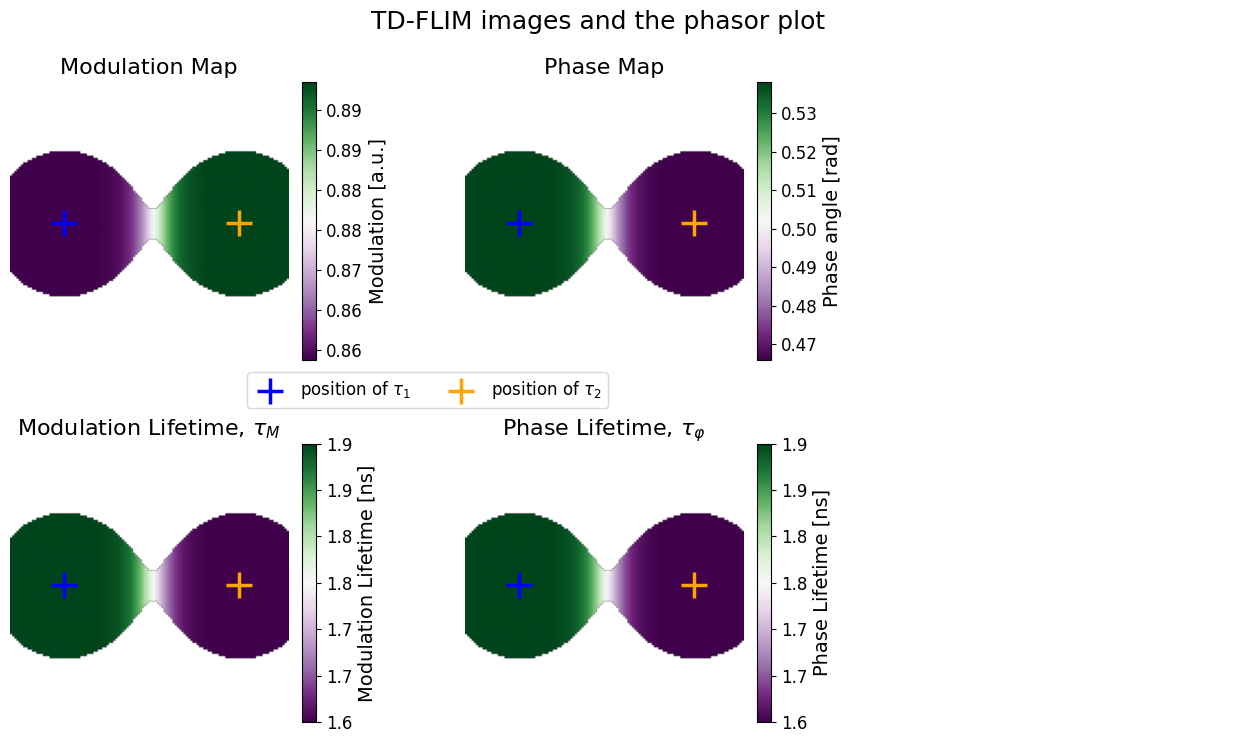

In [30]:
# Parameters for TD-FLIM figure
T = (1 / frequency) * 1e3
laser_period_in_seconds = T * 1e-9
mod_lower_limit = 0.36
phase_lower_limit = 0.1
factor_tm = 1
factor_tp = 1
bins = 100
color = 'PRGn'

#TD-FLIM for Sparrow
mod_th_spa, tau_m_th_spa, phase_th_spa, tau_p_th_spa, _, _, f = td_flim_figure(
    real_th_spa,imag_th_spa,laser_period_in_seconds, harmonic = 1,
    mod_correction = False, mod_lower_limit=mod_lower_limit,
    phase_correction = False, phase_lower_limit=phase_lower_limit,
    tau_m_correction = False, factor_tm=factor_tm, tau_p_correction = False,
    factor_tp=factor_tp, num_bins=30, color = color)

### Reverse Phasor Transformation (Verification)

This utility function verifies the integrity of the lifetime maps by reversing the process. It takes the calculated Modulation ($M$) and Phase ($\phi$) maps and transforms them back into Phasor coordinates ($G, S$).

$G = M \cdot \cos(\phi)$
$S = M \cdot \sin(\phi)$

The function generates a 2D histogram (phasor plot) of these reconstructed coordinates. This serves as a sanity check to ensure the calculated maps (Modulation and Phase) still map correctly to the universal semicircle.

In [39]:
""" Reconstructs G and S phasor coordinates from Modulation and Phase maps and
 plots the resulting 2D phasor histogram. """

import matplotlib.colors as colors

def phasor_from_mod_phase(mod_map, phase_map, num_bins = 100, color = 'Blues'):
  G = mod_map * np.cos(phase_map)
  S = mod_map * np.sin(phase_map)

  # Handle NaN values (set to -1 to push them out of the visible plot range)
  G = np.nan_to_num(G, nan=-1)
  S = np.nan_to_num(S, nan=-1)

  # --- Plotting Setup ---
  # Define aesthetic parameters
  color = color
  titlesize = 16
  axsize = 14
  ticksize = 12

  # Universal Semicircle Construction
  # Equation: (x - 0.5)^2 + y^2 = 0.5^2  => x^2 + y^2 - x = 0
  x = np.linspace(-1.0, 1.0, 100)
  y = np.linspace(-1.0, 1.0, 100)
  X, Y = np.meshgrid(x, y)
  F = X ** 2 + Y ** 2 - X

  # Create figure
  fig, ax = plt.subplots(figsize=(7, 4.5))

  # Flatten Data for Histogram
  k = np.asarray(G).reshape(-1)
  v = np.asarray(S).reshape(-1)

  # Generate 2D Histogram
  # Uses LogNorm to better visualize high-density regions (like the fluorophore centers)
  im = ax.hist2d(k, v, bins=num_bins, cmap=color, norm=colors.LogNorm(), linewidths=1)

  # Overlay the Universal Semicircle
  ax.contour(X, Y, F, [0], colors='k', linewidths=2.0, linestyles='--')

  # Formatting
  ax.set_title('Phasor plot from\nmodulation and phase maps', fontsize=titlesize)
  ax.set_xlabel('$G$, real', fontsize=axsize)
  ax.set_ylabel('$S$, imag', fontsize=axsize)

  # Set limits to standard phasor plot range (first quadrant)
  ax.set_xlim([-0.01, 1.01])
  ax.set_ylim([0, 0.6])

  # Tick styling
  ax.tick_params(axis="x", labelsize=ticksize)
  ax.tick_params(axis="y", labelsize=ticksize)

  # Apply standard formatting if function exists
  if 'format_plot' in globals():
      format_plot(ax)

  plt.show()
  return fig

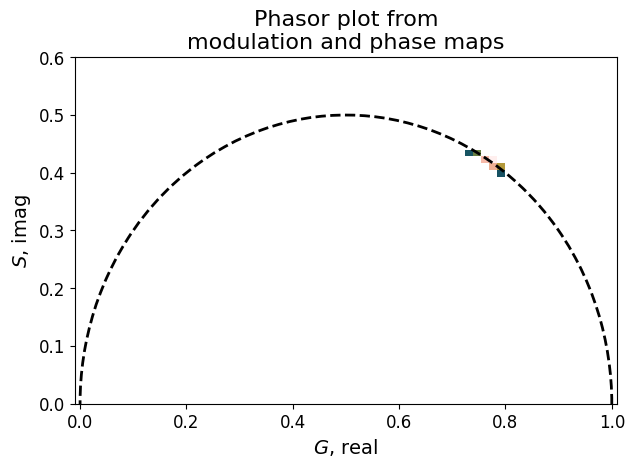

In [40]:
### Plot phasor from modulation and phase maps ###

#Phasor from Sparrow limit
color = 'cmc.batlowW_r'
num_bins = 120
f_phasor = phasor_from_mod_phase(mod_th_spa, phase_th_spa, num_bins, color)


### Phasor Reconstruction from Lifetimes

This function serves as a secondary verification step. It takes the calculated Modulation Lifetime ($\tau_m$) and Phase Lifetime ($\tau_\phi$) maps and transforms them back into Phasor coordinates ($G, S$).

Recover Modulation ($M$) and Phase ($\phi$):\
$M = \frac{1}{\sqrt{1 + (\omega \tau_m)^2}}$* $\tan(\phi) = \omega \tau_\phi$

Calculate Phasor Coordinates:\
$G = M \cos(\phi) = M \cdot \frac{1}{\sqrt{1+\tan^2\phi}} = \frac{1}{\sqrt{1+(\omega \tau_m)^2}} \cdot \frac{1}{\sqrt{1+(\omega \tau_\phi)^2}}$* $S = M \sin(\phi) = G \tan(\phi) = G \cdot \omega \tau_\phi$

This plot allows the visualization of how the calculated lifetimes map back to the universal circle.

In [46]:
""" Reconstructs phasor coordinates (G, S) from Modulation Lifetime and Phase Lifetime maps."""

def phasor_from_modLT_phaseLT(modLT_map, phaseLT_map, T = 12.5, num_bins = 100, color = 'Blues'):
  """ Args:
    modLT_map: Array of modulation lifetimes (tau_m)
    phaseLT_map: Array of phase lifetimes (tau_phi)
    T: Laser period in nanoseconds (default 12.5 ns for 80 MHz, check your frequency!)
    num_bins: Resolution of the 2D histogram
  """

  # Calculate angular frequency
  w = (2 * np.pi) / T

  # --- Inverse Transformation ---
  # Calculate G based on the relationship: G = M * cos(phi)
  # Using identities derived from tau_m and tau_phi definitions
  G = np.sqrt(1 / (((w * modLT_map)**2 + 1) * ((w * phaseLT_map)**2 + 1)))

  # Calculate S based on the relationship: S = G * tan(phi)
  # Since tan(phi) = w * tau_phi
  S = w * phaseLT_map * G

  # Handle NaNs (background pixels)
  G = np.nan_to_num(G, nan=-1)
  S = np.nan_to_num(S, nan=-1)

  # --- Output Figure ---
  titlesize = 16
  suptitle = 18
  axsize = 14
  ticksize = 12

  ## Contour for the phasor plot
  # Generates the universal semicircle for reference
  x = np.linspace(-1.0, 1.0, 100)
  y = np.linspace(-1.0, 1.0, 100)
  X, Y = np.meshgrid(x, y)
  F = X ** 2 + Y ** 2 - X

  # Create a single figure and axis
  fig, ax = plt.subplots(figsize=(7, 4.5))  # Adjust figure size as needed

  # Convert 2D map data to 1D arrays for histogram plotting
  k = np.asarray(G).reshape(-1)
  v = np.asarray(S).reshape(-1)

  # Create the 2D histogram (Phasor Plot)
  im = ax.hist2d(k, v, bins=num_bins, cmap=color, norm=colors.LogNorm(), linewidths=1)

  # Overlay the Universal Semicircle
  ax.contour(X, Y, F, [0], colors='k', linewidths=2.0, linestyles='--')

  # Add title and labels
  ax.set_title('Phasor plot from\nmodulation and phase lifetimes maps', fontsize=titlesize)
  ax.set_xlabel('$G$, real', fontsize=axsize)
  ax.set_ylabel('$S$, imag', fontsize=axsize)

  # Adjust limits to focus on the first quadrant
  ax.set_xlim([-0.01, 1.01])
  ax.set_ylim([0, 0.6])

  # Adjust tick labels
  ax.tick_params(axis="x", labelsize=ticksize)
  ax.tick_params(axis="y", labelsize=ticksize)

  # Apply standard formatting if available
  if 'format_plot' in globals():
    format_plot(ax)

  # Show the plot
  plt.show()
  return fig

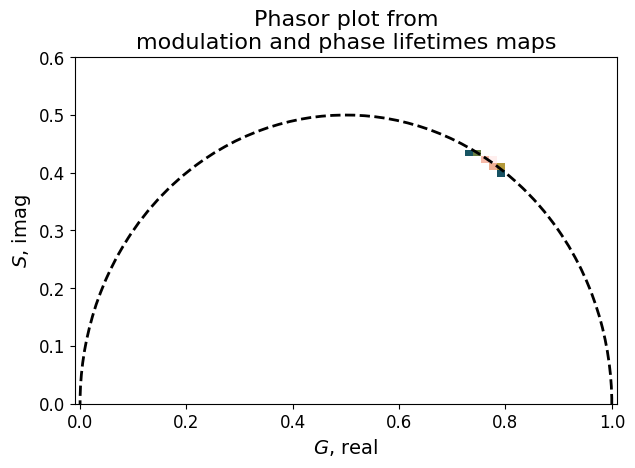

In [47]:
### Plot phasor from modulation lifetimes and phase lifetimes maps

T = period

#Phasor from Sparrow
color = 'cmc.batlowW_r'
num_bins = 120
f_phasor = phasor_from_modLT_phaseLT(tau_m_th_spa, tau_p_th_spa, T, num_bins, color)